In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from readability import Readability
from itertools import combinations
import scipy.stats
import itertools
from tqdm import tqdm

In [ ]:
model_dir = os.environ.get('READABILITY_ANALYSIS_MODEL_DIR')

In [5]:
survey_df = pd.read_csv(model_dir + 'df_post_survey_all.csv')

<Axes: xlabel='article_read_ease', ylabel='Count'>

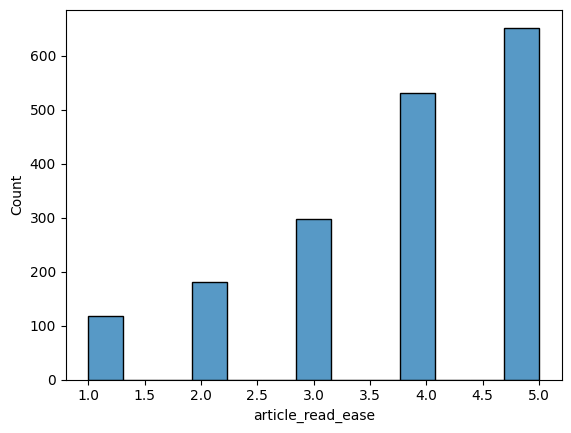

In [6]:
sns.histplot(survey_df['article_read_ease'])

In [7]:
metric_names = [
          "coleman_liau",
           "dale_chall",
           "gunning_fog",
          "flesch",
           "spache",
           "ari",
           "linsear_write",
           ]
def get_readability_metrics(text):
  r = Readability(text)
  scores = {}
  for m_name in metric_names:
    f = getattr(r, m_name)
    try:
      scores[m_name] = f().score
    except:
      scores[m_name] = -1
  return scores

In [8]:
clean_summ_df = pd.read_csv(model_dir + "cleaned_summaries.csv")
clean_summ_df.head()

,name,textVersion,studyName,studyNum,cleanText,r-flesch_kincaid,r-gunning_fog,r-coleman_liau,r-dale_chall,r-ari,r-linsear_write,r-spache,s-article_read_ease,s-article_understanding,s-article_interest,s-valuable_info
0,redditCommentsARDS,Low,text_expert (Study 1),1,Scientists create a device which can detect th...,14.942389,18.585356,12.726358,11.273107,16.659181,19.500000,8.732246,4.043478,3.739130,3.478261,4.086957
1,redditCommentsARDS,Low,text_expert (Study 1),2,Scientists create a device which can detect th...,14.942389,18.585356,12.726358,11.273107,16.659181,19.500000,8.732246,4.250000,3.958333,4.208333,4.208333
2,redditCommentsARDS,Low,text_expert (Study 1),3,Scientists create a device which can detect th...,14.942389,18.585356,12.726358,11.273107,16.659181,19.500000,8.732246,3.157895,3.368421,3.105263,3.947368
3,redditCommentsARDS,Low,text_gpt3 (Study 2),1,"\r\n\r\nWhen someone has a lung problem, docto...",8.867698,11.420317,8.966870,7.890558,9.662152,11.769231,5.945578,4.043478,3.739130,3.478261,4.086957
4,redditCommentsARDS,Low,text_gpt3 (Study 2),2,"\r\n\r\nWhen someone has a lung problem, docto...",8.867698,11.420317,8.966870,7.890558,9.662152,11.769231,5.945578,4.250000,3.958333,4.208333,4.208333


In [9]:
scores = clean_summ_df["cleanText"].apply(get_readability_metrics)
for m_name in metric_names:
  m_scores = scores.apply(lambda r: r[m_name])
  clean_summ_df[f"r-{m_name}"] = m_scores

In [ ]:
def read_model_outputs(model_name):
    tmp = pd.read_csv(model_dir + f"{model_name}.csv")
    sub_name = model_name.split("/")[1]
    clean_summ_df[f"r-{sub_name}"] = tmp['reading_ease']

In [ ]:
## Llama-3.1-8B-Instruct
read_model_outputs("meta-llama/Llama-3.1-8B-Instruct")

In [ ]:
# Llama-3.3-70B-Instruct
read_model_outputs("meta-llama/Llama-3.3-70B-Instruct")

In [ ]:
# Mistral AI
read_model_outputs("mistralai/Mistral-7B-Instruct-v0.3")
read_model_outputs("mistralai/Mixtral-8x7B-Instruct-v0.1")

In [ ]:
#OlMo 
read_model_outputs("allenai/OLMo-2-1124-7B-Instruct")
read_model_outputs("allenai/OLMo-2-1124-13B-Instruct")

In [ ]:
## gemma-7b-it 
read_model_outputs("google/gemma-7b-it")

In [ ]:
all_model_names =  [
                    "OLMo-2-1124-7B-Instruct",
                    "OLMo-2-1124-13B-Instruct",
                    "Mistral-7B-Instruct-v0.3",
                    'gemma-7b-it',
                    "Mixtral-8x7B-Instruct-v0.1",
                    'Llama-3.1-8B-Instruct',
                    'Llama-3.3-70B-Instruct',
                    ]

In [17]:
all_paper_names = clean_summ_df["name"].unique()
text_versions = clean_summ_df["textVersion"].unique()
study_names = ['text_expert (Study 1)', 'text_gpt3 (Study 2)', 'text_gpt3.5 (Study 3)']
study_num = [1,2,3]
all_summary_types = list(itertools.product(all_paper_names, text_versions, study_names, study_num))

In [18]:
def get_mean_attr_value(df, paper_name, text_version, study, attr):
  tmp = df[df['paperId']==paper_name]
  tmp = tmp[tmp['study']==study]
  tmp = tmp[tmp['complexityLevel']==text_version]
  return tmp[attr].mean()

avg_attr_values = {}
attr_names = ['article_read_ease','article_understanding', 'article_interest', 'valuable_info']
for attr_name in attr_names:
  this_attr = []
  for paper_name, t_version, _, study_num in all_summary_types:
    mean_attr = get_mean_attr_value(survey_df, paper_name, t_version, study_num, attr_name)
    this_attr.append(mean_attr)
  clean_summ_df[f"s-{attr_name}"] = this_attr

In [24]:
all_metric_names = metric_names + all_model_names
attr_metric_combos = list(itertools.product(all_metric_names, attr_names))
all_correlations_pearson = np.zeros((len(all_metric_names), len(attr_names)))
all_correlations_kt = np.zeros((len(all_metric_names), len(attr_names)))
err = np.empty_like(all_correlations_pearson)
neg_metrics = ["coleman_liau", "dale_chall", "gunning_fog", "spache","ari"]
for m_idx, metric_name in enumerate(all_metric_names):
  for a_idx, attr_name in enumerate(attr_names):
    tmp = clean_summ_df[[f"r-{metric_name}", f"s-{attr_name}"]]
    if metric_name in neg_metrics:
      tmp[f"r-{metric_name}"] *= -1
    pearson = scipy.stats.pearsonr(tmp.iloc[:,0],tmp.iloc[:,1])
    kendall = scipy.stats.kendalltau(tmp.iloc[:,0],tmp.iloc[:,1])
    all_correlations_pearson[m_idx, a_idx] = pearson.statistic
    all_correlations_kt[m_idx, a_idx] = kendall.statistic
    err[m_idx, a_idx] = pearson.pvalue < 0.05
print(all_correlations_pearson)
print(all_correlations_kt)

[[ 0.32427753  0.23142632  0.11776138  0.10524763]
 [ 0.30564962  0.21476968  0.15420732  0.0621083 ]
 [ 0.21132191  0.11978486  0.05198998  0.0409602 ]
 [ 0.26222167  0.16141035  0.09080471  0.05562457]
 [ 0.11876415  0.03686929 -0.00221843 -0.03597998]
 [ 0.1124973   0.02583694 -0.00771816 -0.01662337]
 [-0.07339127  0.01018588  0.01846753  0.02995054]
 [ 0.01370309 -0.01364177  0.02916257  0.02345986]
 [ 0.20351295  0.18269704  0.03094697  0.01214805]
 [ 0.34857867  0.34334787  0.16065604  0.12798274]
 [ 0.35376363  0.34514446  0.07122419  0.06468613]
 [ 0.39855951  0.33430453  0.11682198  0.10977894]
 [ 0.49038033  0.48733582  0.26961226  0.24712175]
 [ 0.51399297  0.46383594  0.18148633  0.17543205]]
[[ 0.20211174  0.11644252  0.06106872  0.02778617]
 [ 0.21367535  0.1429354   0.10127858 -0.00315752]
 [ 0.13750637  0.05916743  0.01922534  0.0005052 ]
 [ 0.15975375  0.07619857  0.04222035  0.00265232]
 [ 0.06812473  0.00643399 -0.02236673 -0.05999286]
 [ 0.07013579  0.00037847 -0.0

/tmp/ipykernel_1350809/2301268576.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[f"r-{metric_name}"] *= -1


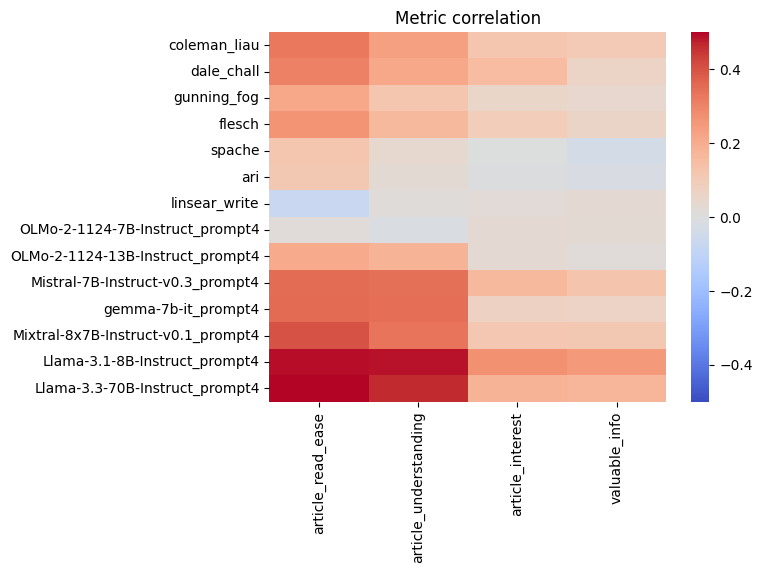

In [26]:
sns.heatmap(all_correlations_pearson, cmap='coolwarm', xticklabels=attr_names, yticklabels=all_metric_names, vmin=-0.5,vmax=0.5)
plt.title("Metric correlation")
plt.show()

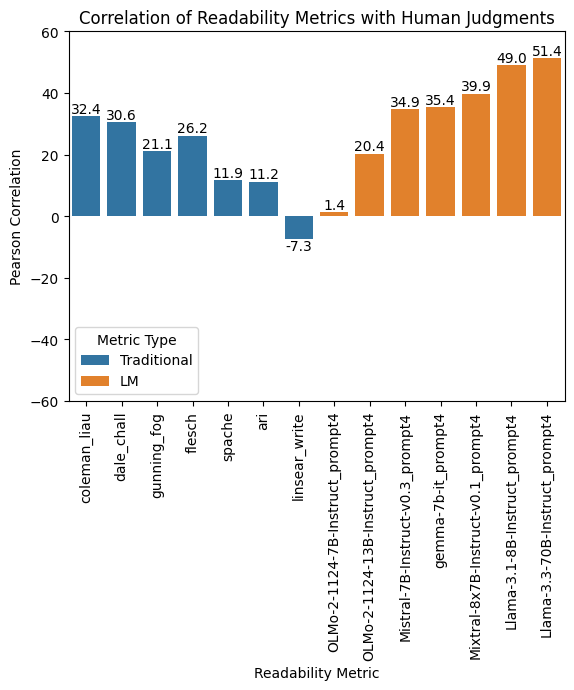

In [27]:
# x_labels = [
# 'Coleman Liau',
#  'Dale-Chall',
#  'Gunning Fog',
#  'Flesch Kincaid',
#  'Spache',
#  'ARI',
#  'Linsear Write',
#  'OLMo-2 7B',
#  'OLMo-2 13B',
#  'Mistral-7B',
#  'gemma-7b',
#  'Mixtral-8x7B',
#  'Llama-3.1-8B',
#  'Llama-3.3-70B'
# ]
hue = ["Traditional"]*7 + ["LM"]*7
plot_df = pd.DataFrame.from_dict(
    {
        "Pearson Correlation":all_correlations_pearson[:,0]*100,
        "Readability Metric": all_metric_names,
        "Metric Type": hue
    }
    )

# ax.set_xticklabels(labels=x_labels, rotation=45)
ax = sns.barplot(plot_df, x="Readability Metric", y="Pearson Correlation", hue="Metric Type")
plt.rcParams["figure.figsize"] = (12,4)
ax.tick_params(axis='x', rotation=90)
for container in ax.containers:
    ax.bar_label(container, fmt='%.01f')
plt.ylim(-60, 60)
plt.title("Correlation of Readability Metrics with Human Judgments")
plt.show()

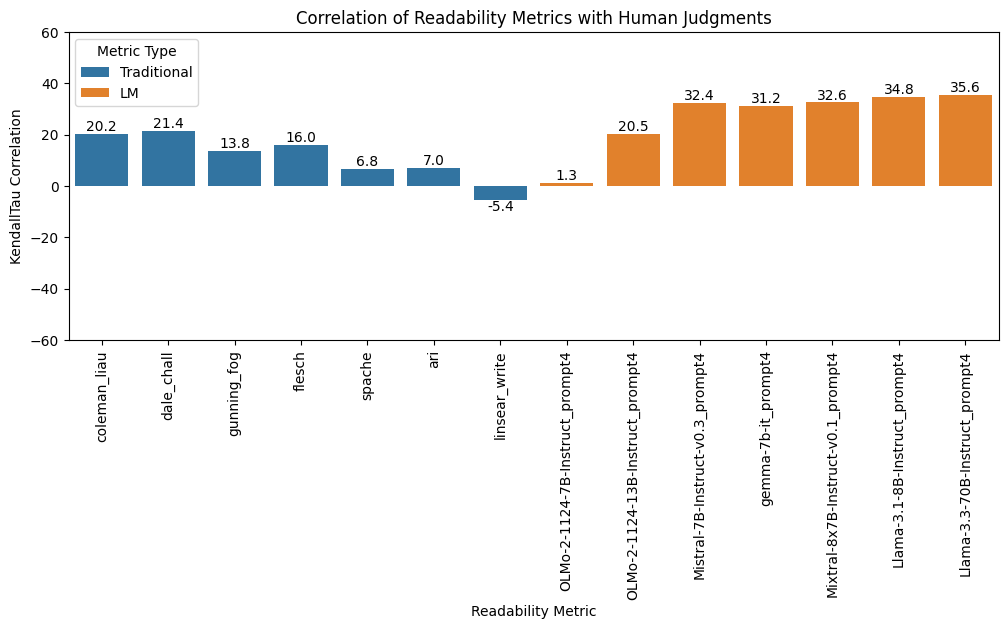

In [28]:
# x_labels = [
# 'Coleman Liau',
#  'Dale-Chall',
#  'Gunning Fog',
#  'Flesch Kincaid',
#  'Spache',
#  'ARI',
#  'Linsear Write',
#  'OLMo-2 7B',
#  'OLMo-2 13B',
#  'Mistral-7B',
#  'gemma-7b',
#  'Mixtral-8x7B',
#  'Llama-3.1-8B',
#  'Llama-3.3-70B'
# ]
hue = ["Traditional"]*7 + ["LM"]*7
plot_df = pd.DataFrame.from_dict(
    {
        "KendallTau Correlation":all_correlations_kt[:,0]*100,
        "Readability Metric": all_metric_names,
        "Metric Type": hue
    }
    )

# ax.set_xticklabels(labels=x_labels, rotation=45)
ax = sns.barplot(plot_df, x="Readability Metric", y="KendallTau Correlation", hue="Metric Type")
plt.rcParams["figure.figsize"] = (12,4)
ax.tick_params(axis='x', rotation=90)
for container in ax.containers:
    ax.bar_label(container, fmt='%.01f')
plt.ylim(-60, 60)
plt.title("Correlation of Readability Metrics with Human Judgments")
plt.show()

In [29]:
hue = []
vals = []
for _, row in clean_summ_df.iterrows():
  for m_name in all_model_names:
    hue.append(m_name)
    vals.append(row[f'r-{m_name}'])
  hue.append('reading_ease')
  vals.append(row['s-article_read_ease'])
df_val_dist = pd.DataFrame({"val_name": hue, "val": vals})
df_val_dist

,val_name,val
0,OLMo-2-1124-7B-Instruct_prompt4,4.000000
1,OLMo-2-1124-13B-Instruct_prompt4,4.000000
2,Mistral-7B-Instruct-v0.3_prompt4,3.500000
3,gemma-7b-it_prompt4,3.000000
4,Mixtral-8x7B-Instruct-v0.1_prompt4,4.000000
...,...,...
1435,gemma-7b-it_prompt4,3.000000
1436,Mixtral-8x7B-Instruct-v0.1_prompt4,3.000000
1437,Llama-3.1-8B-Instruct_prompt4,3.000000
1438,Llama-3.3-70B-Instruct_prompt4,3.000000


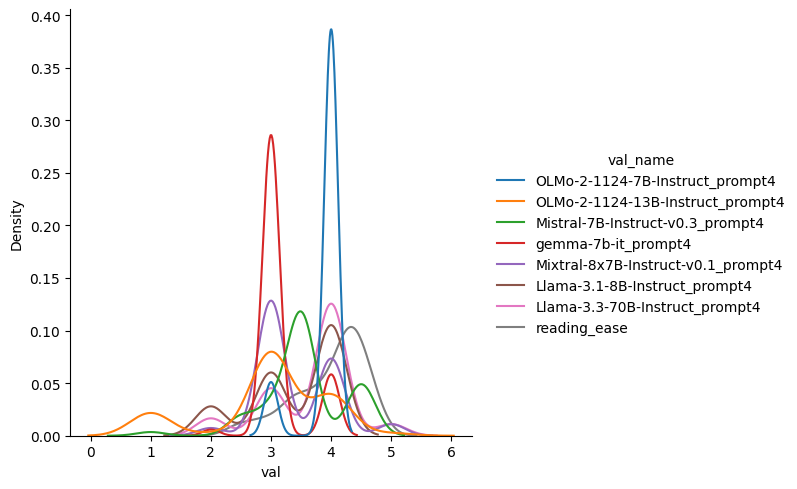

In [30]:
sns.displot(df_val_dist, x='val', hue='val_name', kind="kde")

## Cohen's Kappa

In [31]:
# Calculate inner annotator agreement
def aggreement_per_annotator(df, annotator_id, metric_name):
  annotator_df = df[df["uuid"]==annotator_id]
  paper_ids = annotator_df['paperId'].unique()
  scores = []
  for pid in paper_ids:
    paper_df = df[df['paperId']==pid]
    y2 = []
    this_annotator_val = annotator_df[annotator_df['paperId']==pid][metric_name].iloc[0]
    this_annotator_val = 1 if this_annotator_val > 3 else 0
    for _, row in paper_df.iterrows():
      if row['uuid'] != annotator_id:
        val = row[metric_name]
        y2.append(1 if val > 3 else 0)
    y2 = np.array(y2)
    y1 = np.full_like(y2, this_annotator_val)
    same = sum(y1==y2)
    scores.append(same/len(y1))

  return np.mean(scores)

In [32]:
aggreement_per_annotator(survey_df, '346a567a-78f4-444f-8a35-00a00efc9324', 'article_read_ease')

0.7634293103533906

In [33]:
def aggreement_per_attr(attr):
  n_annotators = len(survey_df['uuid'].unique())
  this_attr = []
  for i, annotator_id in enumerate(survey_df['uuid'].unique()):
    if i % 100 == 0:
      print(f'{i}/{n_annotators}')
    annotator_score = aggreement_per_annotator(survey_df, annotator_id, attr)
    this_attr.append(annotator_score)
  return this_attr

In [34]:
article_read_ease_aggreement = aggreement_per_attr('article_read_ease')
np.mean(article_read_ease_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.6000919589431635

In [35]:
article_understanding_aggreement = aggreement_per_attr('article_understanding')
np.mean(article_understanding_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.6070411441150764

In [36]:
article_interest_aggreement = aggreement_per_attr('article_interest')
np.mean(article_interest_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.5262433625510443

In [37]:
valuable_info_aggreement = aggreement_per_attr('valuable_info')
np.mean(valuable_info_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.5787217490422268